In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import pymorphy2
from pymystem3 import Mystem

from nltk.stem.wordnet import WordNetLemmatizer
import glob
from nltk import word_tokenize
import re
import nltk

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
mystem = Mystem()
morph = pymorphy2.MorphAnalyzer()

def pymorphy_lemmatize_text(text):
    words = []
    for word in clean_text(text):
        words.append(morph.parse(word)[0].normal_form)
    return ' '.join(words)

def mystem_lemmatize_text(text):
    text = ' '.join(clean_text(text))
    text=''.join(mystem.lemmatize(text))
    return text


def tokenize(text):
    text = word_tokenize(text.lower().strip())
    return ''.join(text)

def clean_text(text): 

    #убираем мусор
    text = nltk.re.sub('-\s\r\n\s+|-\s\r\n|\r\n|[«»]|[><]', ' ', text.lower())    
    text = nltk.re.sub('[0-9]|[.,:;_%©?*!@#№$^•·&()\d]|[+=]|[[]|[]]|[/]|"|\s{2,}|-|–|—|', ' ', text)
    text = re.sub(r"\d+", ' ', text, flags=re.UNICODE)
    text = re.sub('\’|\”|‘', ' ', text)
    text = re.sub(r'\\n', '', text)
    text = re.sub('ё', 'е', text)

    #убираем стоп-слова
    words = text.split()
    words = [w for w in words if not w in stopword_ru]

    #джойним слова
    return words

In [3]:
# Фиксирование рандома и прочее
np.random.seed(42)
stopword_ru=stopwords.words('russian')
stopword_ru.append('м')
stopword_ru.append('это')
stopword_ru.append('по')

In [4]:
data = []
for df in glob.glob('/proj_news_viz/data/*.csv'):
    data = pd.read_csv(df, encoding='utf-8')

data = data.drop_duplicates('url')

In [11]:
texts = ''.join(data.text[0:10000])

### Сравнение количества уникальных слов до и после лемматизации: 

In [12]:
words = clean_text(texts)  
print(f'Количество уникальных слов до лемматизации: {len(np.unique(words))}')

Количество уникальных слов до лемматизации: 127967


In [13]:
lem_texts = []
dfs = []
lemmatizers = [pymorphy_lemmatize_text, mystem_lemmatize_text]
for fun in lemmatizers:
    start = np.datetime64('now')
    text = fun(texts)
    lem_texts.append(text)
    print(f'{fun.__name__} - running time: {str(np.datetime64("now") - start)}')  
    words = text.split(' ')      
    print(f'Количество уникальных слов c лемматизацией {fun.__name__}: {len(np.unique(words))}')
    dfs.append(pd.DataFrame({'word':np.unique(words, return_counts=True)[0],
                            'freq': np.unique(words, return_counts=True)[1]}))

    

pymorphy_lemmatize_text - running time: 50 seconds
Количество уникальных слов c лемматизацией pymorphy_lemmatize_text: 56407
mystem_lemmatize_text - running time: 4175 seconds
Количество уникальных слов c лемматизацией mystem_lemmatize_text: 55307


### Пример текста до и после лемматизации:

In [14]:
example = texts[0:624]
example

'Миллиардер Илон Маск в резкой форме ответил британскому дайверу, раскритиковавшему его план по спасению детей из затопленной пещеры в Таиланде. Об этом сообщает The Hollywood Reporter. Спасатель Верн Ансворт, участвовавший в спасательной операции, заявил, что идея Маска о мини-субмарине является пиар-ходом и посоветовал «засунуть эту подлодку куда поглубже». В ответ Маск в своем Twitter назвал оппонента педофилом, отметив, что не видел Ансворта на месте инцидента, а вызволявшие детей тайские морпехи «по-настоящему круты». Позднее он удалил свой твит. Детская футбольная команда пошла в пещеру после тренировки 23 июня.'

In [15]:
lemmatizers = [pymorphy_lemmatize_text, mystem_lemmatize_text]
for fun in lemmatizers:
    print(f'\n{fun.__name__}: \n{fun(example)}')



pymorphy_lemmatize_text: 
миллиардер илона маск резка форма ответить британский дайвера раскритиковать план спасение ребёнок затопить пещера таиланд сообщать the hollywood reporter спасатель верна ансворт участвовать спасательный операция заявить идея маска минь субмарина являться пиар ход посоветовать засунуть подлодка глубокий ответ маск свой twitter назвать оппонент педофил отметить видеть ансворт место инцидент вызволять ребёнок тайский морпех настоящий крутой поздний удалить свой твит детский футбольный команда пошлый пещера тренировка июнь

mystem_lemmatize_text: 
миллиардер илона маск резкий форма отвечать британский дайвер раскритиковывать план спасение ребенок затапливать пещера таиланд сообщать the hollywood reporter спасатель верн ансворт участвовать спасательный операция заявлять идея маска мини субмарина являться пиар ход посоветовать засовывать подлодка глубоко ответ маск свой twitter называть оппонент педофил отмечать видеть ансворт место инцидент вызволять ребенок тайс

### Частотные графики до и после:

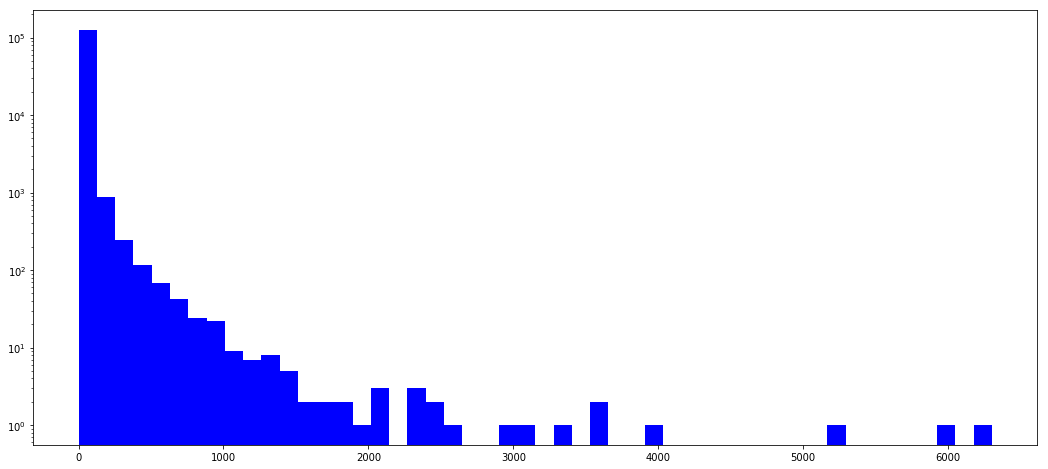

In [16]:
plt.figure(figsize=(18,8))
words = clean_text(texts)  
df = pd.DataFrame({'word':np.unique(words, return_counts=True)[0],
                            'freq': np.unique(words, return_counts=True)[1]})
n, bins, patches = plt.hist(df.freq, bins = 50, facecolor='blue', log=True)
plt.show()

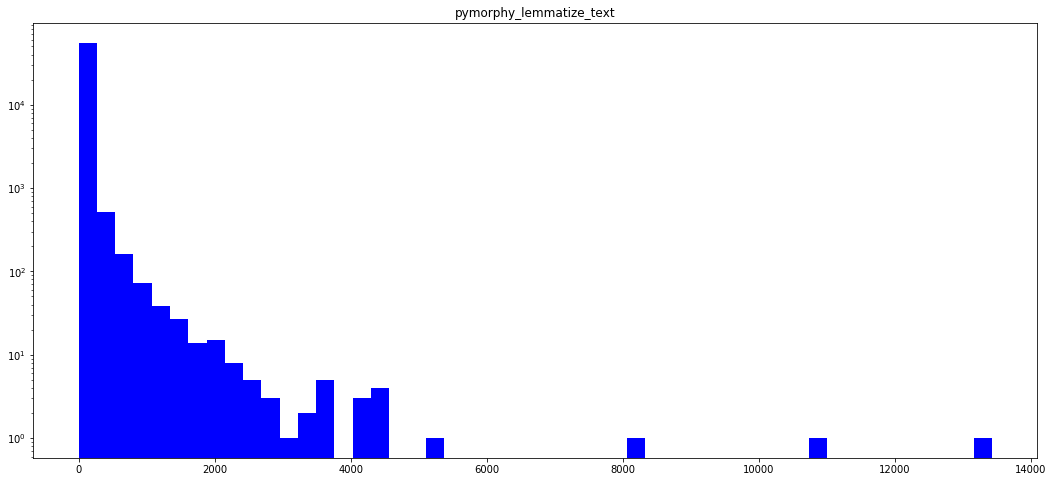

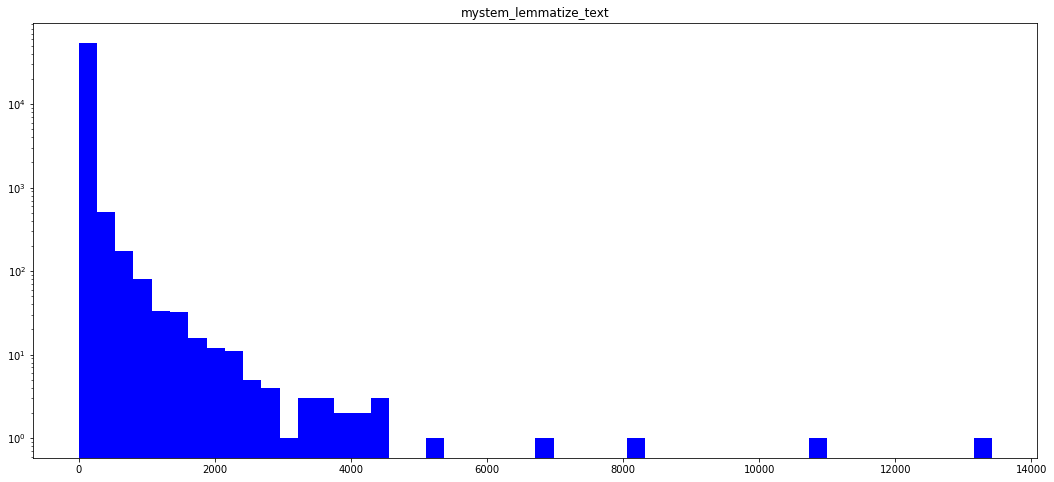

In [17]:
for i, fun in enumerate(lemmatizers):
    plt.figure(figsize=(18,8))
    plt.title(fun.__name__)
    n, bins, patches = plt.hist(dfs[i].freq, bins = 50, facecolor='blue', log=True)
    plt.show()